<a href="https://colab.research.google.com/github/itsmaul/bangkit-capstone/blob/main/All_Integrated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Cashflow Analysis**

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler

## **Visualisasi Data**

In [2]:
def preprocess_data(data):
  # Membaca file dataset
  data = pd.DataFrame(pd.read_json(data))

  # Menghitung total_income dan total_expense
  data['total_income'] = data.apply(lambda x: x['amount'] if x['transaction_type'] == 'Income' else 0, axis=1)
  data['total_expense'] = data.apply(lambda x: x['amount'] if x['transaction_type'] == 'Expense' else 0, axis=1)

  # Menghitung net_cashflow
  data['net_cashflow'] = data['total_income'] - data['total_expense']

  # Mengelompokkan berdasarkan bulan
  data['month'] = pd.to_datetime(data['date']).dt.to_period('M')

  # Menghitung total per bulan
  summary = data.groupby('month').agg(
    total_income = ('total_income', 'sum'),
    total_expense = ('total_expense', 'sum'),
    net_cashflow = ('net_cashflow', 'sum')
  ).reset_index()

  # Period ke timestamp
  summary['month'] = summary['month'].dt.to_timestamp()

  return summary

In [3]:
data = preprocess_data('merger_dataset.json')
data.head(10)

,month,total_income,total_expense,net_cashflow
0,2023-08-01,1390000,1412950,-22950
1,2023-09-01,1607000,1443530,163470
2,2023-10-01,1510000,1652785,-142785
3,2023-11-01,1200000,1077068,122932
4,2023-12-01,1750000,1829508,-79508
5,2024-01-01,9735000,11400361,-1665361
6,2024-02-01,19201015,18971500,229515
7,2024-03-01,3620000,2670818,949182
8,2024-04-01,6250101,4098822,2151279
9,2024-05-01,4527000,6434944,-1907944


In [4]:
#Min-Max Scaler Initialization
income_scaler = MinMaxScaler(feature_range=(0, 1))
expense_scaler = MinMaxScaler(feature_range=(0, 1))
cashflow_scaler = MinMaxScaler(feature_range=(0, 1))

In [5]:
def time_series(data):
  # Rescaling dengan MinMaxScaler
  total_income = income_scaler.fit_transform(data[['total_income']])
  total_expense = expense_scaler.fit_transform(data[['total_expense']])
  net_cashflow = cashflow_scaler.fit_transform(data[['net_cashflow']])

  # Assign value variabel time dan series
  time = data['month'].tolist()
  income = total_income.tolist()
  expense = total_expense.tolist()
  net_cashflow = net_cashflow.tolist()

  return time, income, expense, net_cashflow

In [6]:
TIME, INCOME, EXPENSE, NET_CASHFLOW = time_series(data)

INCOME_SCALED = income_scaler.inverse_transform(np.array(INCOME).reshape(-1,1)).flatten()
EXPENSE_SCALED = expense_scaler.inverse_transform(np.array(EXPENSE).reshape(-1,1)).flatten()
NET_CASHFLOW_SCALED = cashflow_scaler.inverse_transform(np.array(NET_CASHFLOW).reshape(-1,1)).flatten()

In [7]:
#Visualisasi Data

def plot_value(time, value, label):
  plt.plot(time, value, label = label)
  formatter = ticker.ScalarFormatter()
  formatter.set_scientific(False)
  plt.xlabel("Bulan Transaksi")
  plt.ylabel("Jumlah Uang")
  plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
  plt.gca().yaxis.set_major_formatter(formatter)
  plt.legend()
  plt.gcf().autofmt_xdate()
  plt.show()

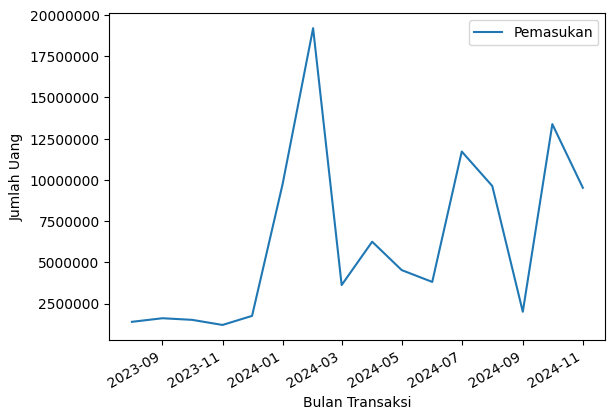

In [8]:
plot_value(TIME, INCOME_SCALED, "Pemasukan")

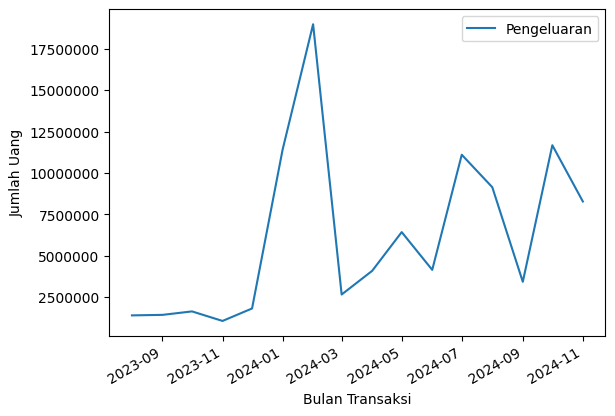

In [9]:
plot_value(TIME, EXPENSE_SCALED, "Pengeluaran")

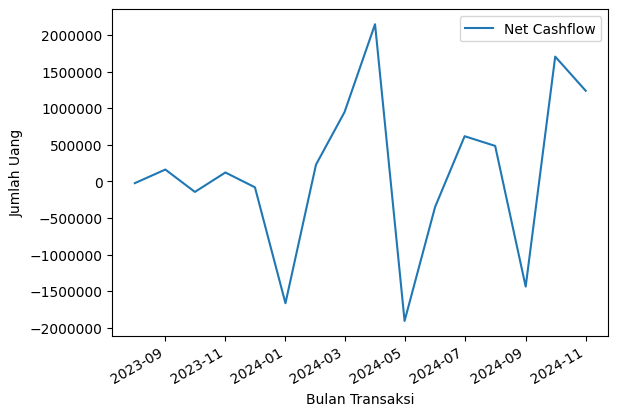

In [10]:
plot_value(TIME, NET_CASHFLOW_SCALED, "Net Cashflow")

In [11]:
# Format data JSON
data_for_export = {
  "cashflow_analysis": [
    {
      "time": TIME[i].strftime('%Y-%m'),
      "total_income": INCOME[i],
      "total_expense": EXPENSE[i],
      "net_cashflow": NET_CASHFLOW[i]
    }
    for i in range(len(TIME))
  ]
}

# Simpan ke JSON
with open('clean_data.json', 'w') as json_file:
    json.dump(data_for_export, json_file, indent=1)

# **Prediksi Keuangan (Anomaly Autoencoder)**

In [12]:
def preprocess_data(data):
    # Convert 'date' to datetime and extract features
    data['date'] = pd.to_datetime(data['date'])
    data['day_of_week'] = data['date'].dt.dayofweek  # Day of the week (0=Monday, 6=Sunday)
    data['month'] = data['date'].dt.month           # Month of the year (1=January, 12=December)
    data['day_of_month'] = data['date'].dt.day      # Day of the month (1-31)

    # Select relevant features
    features = ['amount', 'day_of_week', 'month', 'day_of_month']
    data = data[features]

    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    return data_scaled, data, scaler

In [13]:
# Function to build the autoencoder model
def build_autoencoder(input_dim):
    """
    Builds and compiles an autoencoder model.

    Parameters:
        input_dim (int): Number of input features.

    Returns:
        tf.keras.Model: Compiled autoencoder model.
    """
    autoencoder = models.Sequential([
        layers.Input(shape=(input_dim,)),       # Input layer
        layers.Dense(32, activation='relu'),    # Encoder
        layers.Dense(16, activation='relu'),    # Encoder
        layers.Dense(8, activation='relu'),     # Bottleneck
        layers.Dense(16, activation='relu'),    # Decoder
        layers.Dense(32, activation='relu'),    # Decoder
        layers.Dense(input_dim, activation='sigmoid')  # Output layer
    ])
    autoencoder.compile(optimizer=optimizers.Adam(), loss='mse')
    return autoencoder

In [14]:
# Function to detect anomalies
def detect_anomalies(autoencoder, data_scaled, original_data, scaler, percentile=95):
    """
    Detects anomalies using the trained autoencoder.

    Parameters:
        autoencoder (tf.keras.Model): Trained autoencoder model.
        data_scaled (np.ndarray): Normalized input data.
        original_data (pd.DataFrame): Original data with features.
        scaler (MinMaxScaler): Scaler used for normalization.
        percentile (float): Percentile threshold for anomaly detection.

    Returns:
        pd.DataFrame: Data with anomaly status and reconstruction errors.
        pd.DataFrame: Detected anomalies.
    """
    # Reconstruct the input data
    reconstructed = autoencoder.predict(data_scaled)
    mse = np.mean(np.power(data_scaled - reconstructed, 2), axis=1)  # Reconstruction error

    # Set anomaly threshold
    threshold = np.percentile(mse, percentile)

    # Flag anomalies
    original_data['reconstruction_error'] = mse
    original_data['is_anomaly'] = mse > threshold

    # Filter anomalies
    anomalies = original_data[original_data['is_anomaly']]

    return original_data, anomalies

In [15]:
# Function to plot the data
def plot_results(processed_data, anomalies):
    """
    Plots the data, highlighting anomalies in red and normal data in blue.

    Parameters:
        processed_data (pd.DataFrame): Dataframe with anomaly status.
        anomalies (pd.DataFrame): Detected anomalies.
    """
    plt.figure(figsize=(10, 6))

    # Plot normal data
    normal_data = processed_data[~processed_data['is_anomaly']]
    plt.scatter(normal_data.index, normal_data['amount'], color='blue', label='Normal', alpha=0.6)

    # Plot anomalies
    plt.scatter(anomalies.index, anomalies['amount'], color='red', label='Anomaly', alpha=0.8)

    # Add labels and legend
    plt.title('Anomaly Detection in Financial Transactions')
    plt.xlabel('Index')
    plt.ylabel('Amount')
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
# Main function to run the pipeline
def main_pipeline(data, epochs=50, batch_size=16, percentile=95):
    """
    Main pipeline for anomaly detection using autoencoder.

    Parameters:
        data (pd.DataFrame): Input dataframe with 'date' and 'amount' columns.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        percentile (float): Percentile threshold for anomaly detection.

    Returns:
        tf.keras.Model: Trained autoencoder model.
        pd.DataFrame: Processed data with anomaly status.
        pd.DataFrame: Detected anomalies.
        MinMaxScaler: Scaler used for data normalization.
        float: Threshold for anomaly detection based on reconstruction error.
    """
    # Step 1: Preprocess the data
    data_scaled, processed_data, scaler = preprocess_data(data)

    # Step 2: Build the autoencoder
    input_dim = data_scaled.shape[1]
    autoencoder = build_autoencoder(input_dim)

    # Step 3: Train the autoencoder
    history = autoencoder.fit(data_scaled, data_scaled, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)

    # Step 4: Detect anomalies
    processed_data, anomalies = detect_anomalies(autoencoder, data_scaled, processed_data, scaler, percentile=percentile)

    # Step 5: Plot results
    plot_results(processed_data, anomalies)

    return autoencoder, processed_data, anomalies, scaler

In [17]:
def predict_pipeline(model, new_data, scaler, percentile):
    """
    Pipeline to preprocess data, predict anomalies, and plot results using a trained model.

    Parameters:
        model (tf.keras.Model): Trained autoencoder model.
        new_data (pd.DataFrame): New data with the same structure as training data.
        scaler (MinMaxScaler): Scaler used to preprocess the training data.
        threshold (float): Threshold for anomaly detection based on reconstruction error.

    Returns:
        pd.DataFrame: New data with anomaly status and reconstruction errors.
        pd.DataFrame: Detected anomalies.
    """
    # Step 1: Preprocess new data
    # Extract date-based features if not already extracted
    if 'day_of_week' not in new_data.columns:
        new_data['date'] = pd.to_datetime(new_data['date'])
        new_data['day_of_week'] = new_data['date'].dt.dayofweek
        new_data['month'] = new_data['date'].dt.month
        new_data['day_of_month'] = new_data['date'].dt.day
        new_data = new_data[['amount', 'day_of_week', 'month', 'day_of_month']]

    # Normalize the data using the scaler from training
    new_data_scaled = scaler.transform(new_data)

    # Step 2: Use model to reconstruct data
    reconstructed = model.predict(new_data_scaled)
    mse = np.mean(np.power(new_data_scaled - reconstructed, 2), axis=1)

    # Step 3: Detect anomalies
    # Set anomaly threshold
    threshold = np.percentile(mse, percentile)

    # Flag the anomalies
    new_data['reconstruction_error'] = mse
    new_data['is_anomaly'] = mse > threshold

    # Step 4: Filter anomalies
    anomalies = new_data[new_data['is_anomaly']]

    # Step 5: Plot results
    plot_results(new_data, anomalies)

    return new_data, anomalies

In [18]:
def training_pipeline(model, data, scaler, epochs=100, batch_size=16):
    """
    Simplified pipeline to preprocess data and retrain an existing autoencoder model.

    Parameters:
        model (tf.keras.Model): Pre-trained autoencoder model.
        data (pd.DataFrame): Input data with 'date' and 'amount' columns.
        scaler (MinMaxScaler): Scaler used to preprocess the data during initial training.
        epochs (int): Number of epochs for retraining.
        batch_size (int): Batch size for training.

    Returns:
        tf.keras.Model: Retrained autoencoder model.
    """
    # Step 1: Preprocess the data using the existing scaler
    if 'day_of_week' not in data.columns:
        data['date'] = pd.to_datetime(data['date'])
        data['day_of_week'] = data['date'].dt.dayofweek
        data['month'] = data['date'].dt.month
        data['day_of_month'] = data['date'].dt.day
        data = data[['amount', 'day_of_week', 'month', 'day_of_month']]

    data_scaled = scaler.transform(data)

    # Step 2: Retrain the autoencoder
    model.fit(data_scaled, data_scaled, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)

    return model

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1140
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0509
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0295
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0134
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0043
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0027
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0035
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0028
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0028
Epoch 11/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0030
Epoch 12/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027
Epoch 13/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031
Epoch 14/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0035
Epoch 15/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0

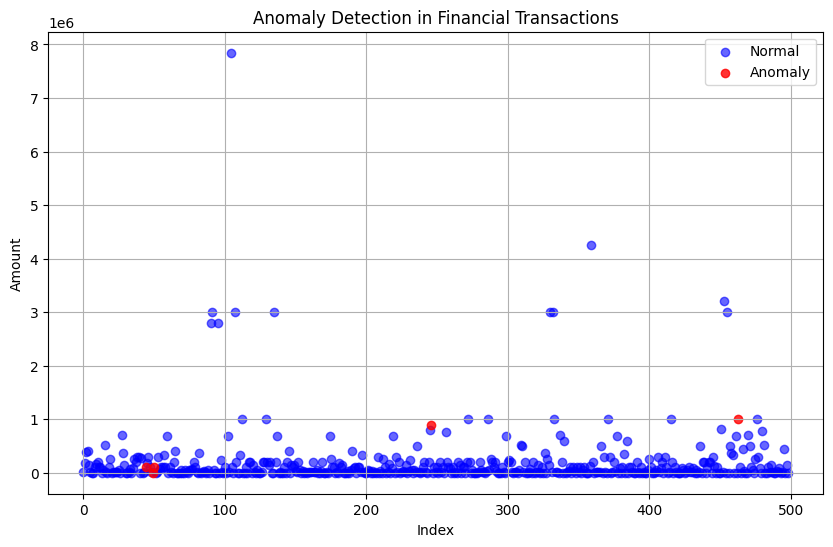

Processed Data with Anomaly Status:
     amount  day_of_week  month  day_of_month  reconstruction_error  \
0     20000            3      8             3              0.000348   
1    186450            1      8             8              0.000216   
2    384000            5      8            12              0.000447   
3    400000            5      8            12              0.000478   
4    150000            0      8            14              0.000340   
..      ...          ...    ...           ...                   ...   
494    5500            5     11            16              0.000386   
495  437000            0     11            18              0.000481   
496    2500            0     11            18              0.000303   
497  150000            0     11            18              0.000248   
498    2500            0     11            18              0.000303   

     is_anomaly  
0         False  
1         False  
2         False  
3         False  
4         False  
.. 

In [19]:
# Example usage
if __name__ == "__main__":
    # Example dataset
    data = pd.read_json('expense_data.json')

    # Run the pipeline
    autoencoder, processed_data, anomalies, scaler = main_pipeline(data, epochs=100, batch_size=4, percentile=99)

    # Display results
    print("Processed Data with Anomaly Status:")
    print(processed_data)

    print("\nDetected Anomalies:")
    print(anomalies)

In [20]:
pf_data = pd.read_json('expense_data.json')

training_pipeline(model=autoencoder, data=pf_data, scaler=scaler, epochs=100, batch_size=4)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8190e-04
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.5824e-04
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8291e-04
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4424e-04
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9845e-04
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7385e-04
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6545e-04
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0983e-04
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0655e-04
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.0238e-04
Epoch 11/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4732e-04
Epoch 12/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.1481e-04
Epoch 13/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.2343e-04
Epoch 14/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

<Sequential name=sequential, built=True>

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


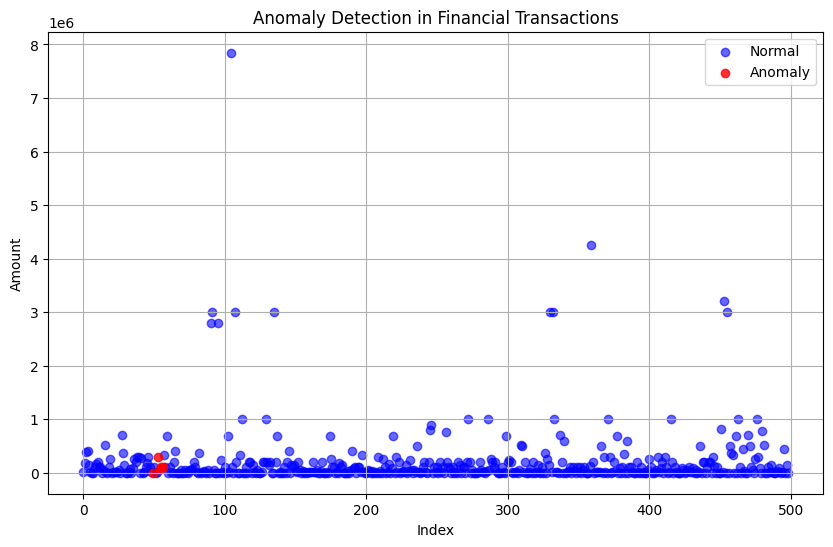

(     amount  day_of_week  month  day_of_month  reconstruction_error  \
 0     20000            3      8             3              0.000290   
 1    186450            1      8             8              0.000078   
 2    384000            5      8            12              0.000350   
 3    400000            5      8            12              0.000359   
 4    150000            0      8            14              0.000067   
 ..      ...          ...    ...           ...                   ...   
 494    5500            5     11            16              0.000337   
 495  437000            0     11            18              0.000482   
 496    2500            0     11            18              0.000442   
 497  150000            0     11            18              0.000396   
 498    2500            0     11            18              0.000442   
 
      is_anomaly  
 0         False  
 1         False  
 2         False  
 3         False  
 4         False  
 ..          ...  
 

In [21]:
pf_data = pd.read_json('expense_data.json')

predict_pipeline(model=autoencoder, new_data=pf_data, scaler=scaler, percentile=99)

In [22]:
pf_data = pd.read_json('income_data.json')

training_pipeline(model=autoencoder, data=pf_data, scaler=scaler, epochs=100, batch_size=4)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018     
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7204e-04
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0366e-04 
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014     
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018     
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5579e-04
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7748e-04
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9289e-04 
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0018
Epoch 13/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5413e-04
Epoch 14/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.5965e-04
Epoch 15/100
27/27 ━━━━━━━

<Sequential name=sequential, built=True>

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


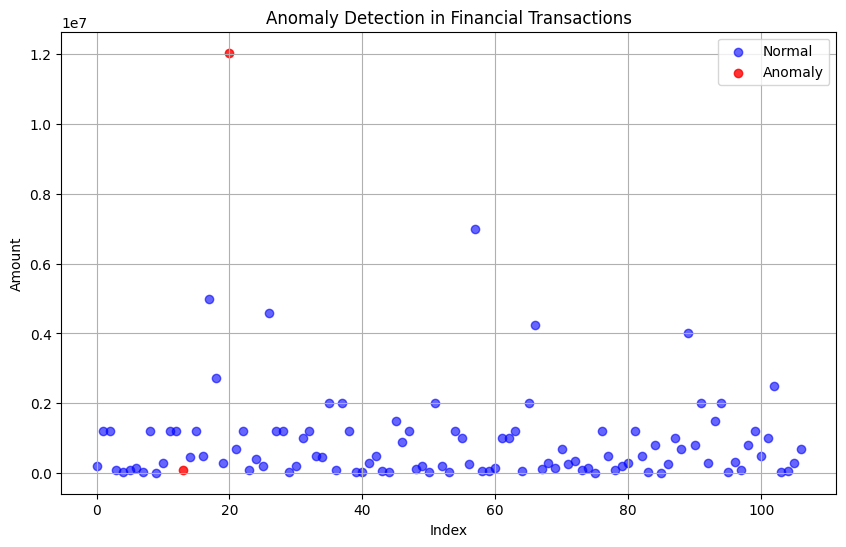

(      amount  day_of_week  month  day_of_month  reconstruction_error  \
 0     190000            1      8             8              0.000644   
 1    1200000            4      8            11              0.000558   
 2    1200000            4      9             1              0.000919   
 3     100000            0      9             4              0.000258   
 4      37000            3      9            14              0.000741   
 ..       ...          ...    ...           ...                   ...   
 102  2500000            3     11             7              0.000249   
 103    40000            1     11            12              0.000176   
 104    50000            2     11            13              0.000106   
 105   300000            4     11            15              0.000186   
 106   700000            0     11            18              0.000128   
 
      is_anomaly  
 0         False  
 1         False  
 2         False  
 3         False  
 4         False  
 ..     

In [23]:
pf_data = pd.read_json('income_data.json')

predict_pipeline(model=autoencoder, new_data=pf_data, scaler=scaler, percentile=99)

# **Anomaly Detection**

In [24]:
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [25]:
class AdvancedFinancialAnomalyDetector:
    def __init__(self, contamination=0.05):
        self.scaler_amount = StandardScaler()
        self.model = IsolationForest(
            contamination=contamination,
            random_state=42,
            max_samples='auto',
            max_features=1.0
        )
        self.amount_column = None

    def preprocess_data(self, data):
        for col in ['amount', 'income', 'expense']:
            if col in data.columns:
                self.amount_column = col
                break
        else:
            raise KeyError("Neither 'amount', 'income', nor 'expense' column found in data")

        # Assuming you have a 'date' column in your data
        data['date'] = pd.to_datetime(data['date'])
        data['day_of_week'] = data['date'].dt.dayofweek
        data['month'] = data['date'].dt.month
        data['day_of_month'] = data['date'].dt.day

        # Normalisasi amount
        features = [self.amount_column, 'day_of_week', 'month', 'day_of_month']
        X = data[features].copy()
        X[self.amount_column] = self.scaler_amount.fit_transform(X[[self.amount_column]])

        return X

    def detect_anomalies(self, data):
        """
        Deteksi anomali dengan informasi detail
        """
        X = self.preprocess_data(data)

        # Prediksi anomali
        anomaly_labels = self.model.fit_predict(X)
        anomaly_scores = -self.model.score_samples(X)

        # Tambahkan informasi ke dataframe asli
        data['is_anomaly'] = anomaly_labels == -1
        data['anomaly_score'] = anomaly_scores

        return data

    def visualize_anomalies(self, data):
        """
        Visualisasi anomali dengan beberapa plot
        """
        plt.figure(figsize=(16, 12))
        plt.subplots_adjust(hspace=0.4, wspace=0.3)

        # 1. Scatter Plot Anomali
        plt.subplot(2, 2, (1, 2))
        plt.title('Deteksi Anomali Keuangan', fontsize=12)
        plt.scatter(
            data[~data['is_anomaly']]['date'],
            data[~data['is_anomaly']][self.amount_column],
            c='blue',
            alpha=0.5,
            label='Normal'
        )
        plt.scatter(
            data[data['is_anomaly']]['date'],
            data[data['is_anomaly']][self.amount_column],
            c='red',
            label='Anomali'
        )
        plt.xlabel('Tanggal')
        plt.ylabel('Jumlah Transaksi')
        plt.legend()
        plt.xticks(rotation=45)

        # 2. Histogram Anomali Scores
        plt.subplot(2, 2, 3)
        plt.title('Distribusi Anomaly Scores', fontsize=12)
        sns.histplot(
            data=data,
            x='anomaly_score',
            hue='is_anomaly',
            multiple='stack'
        )
        plt.xlabel('Anomaly Score')
        plt.ylabel('Frekuensi')

        # 3. Pie Chart Proporsi Anomali
        plt.subplot(2, 2, 4)
        anomaly_counts = data['is_anomaly'].value_counts()
        plt.title('Proporsi Anomali', fontsize=12)
        plt.pie(
            anomaly_counts,
            labels=['Normal', 'Anomali'],
            autopct='%1.1f%%',
            colors=['blue', 'red']
        )

        plt.tight_layout()
        plt.show()

    def detailed_anomaly_report(self, data):
        """
        Laporan detail anomali
        """
        anomalies = data[data['is_anomaly']]

        print("=== LAPORAN DETEKSI ANOMALI ===")
        print(f"Total Transaksi: {len(data)}")
        print(f"Jumlah Anomali: {len(anomalies)}")
        print(f"Persentase Anomali: {len(anomalies)/len(data)*100:.2f}%")

        print("\n--- Detail Anomali ---")
        for idx, row in anomalies.iterrows():
            print(f"Tanggal: {row['date'].date()}")
            print(f"Jumlah: Rp {row[self.amount_column]:,.2f}")
            print(f"Anomaly Score: {row['anomaly_score']:.4f}")
            print("---")

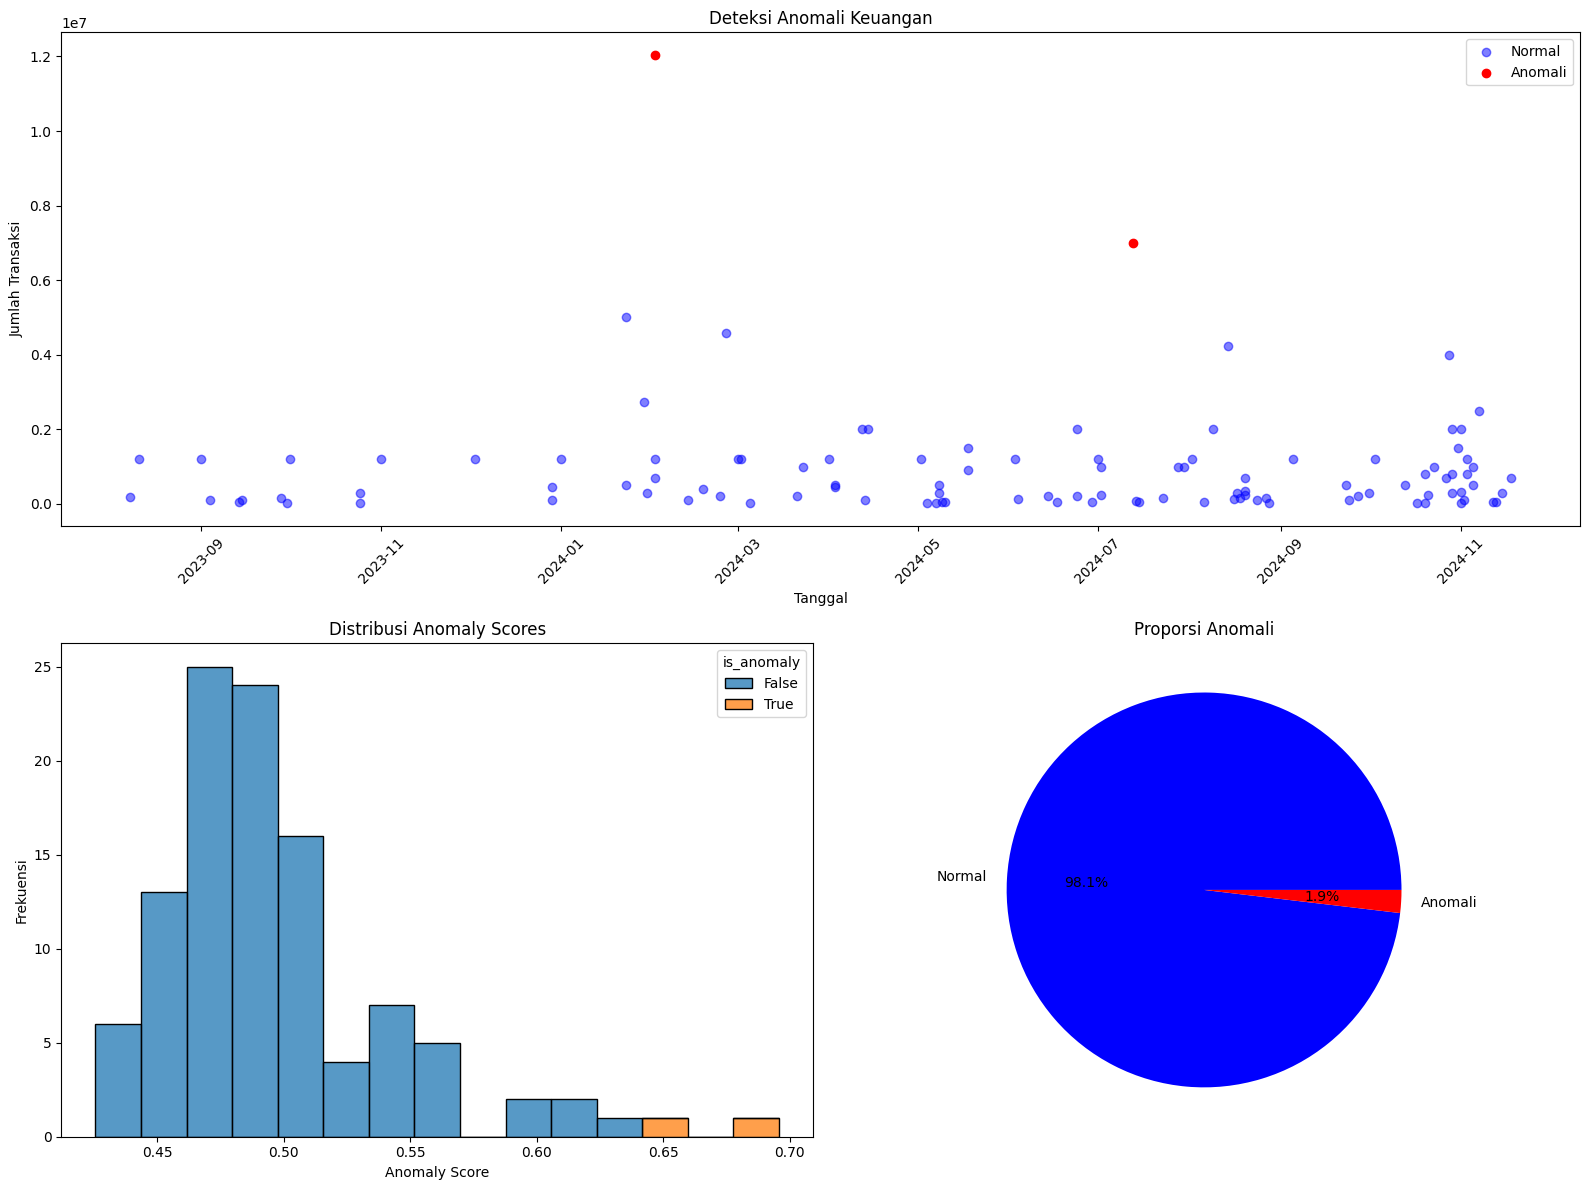

In [26]:
def main_income():
    detector = AdvancedFinancialAnomalyDetector(contamination=0.01)

    # Generate synthetic data
    data = pd.read_json('income_data.json')

    # Detect anomalies
    result = detector.detect_anomalies(data)

    # Visualisasi
    detector.visualize_anomalies(result)

    # Detailed Report
    detector.detailed_anomaly_report(result)

if __name__ == "__main__":
    main_income()

=== LAPORAN DETEKSI ANOMALI ===
Total Transaksi: 107
Jumlah Anomali: 2
Persentase Anomali: 1.87%

--- Detail Anomali ---
Tanggal: 2024-02-02
Jumlah: Rp 12,045,000.00
Anomaly Score: 0.6958
---
Tanggal: 2024-07-13
Jumlah: Rp 7,000,000.00
Anomaly Score: 0.6515
---


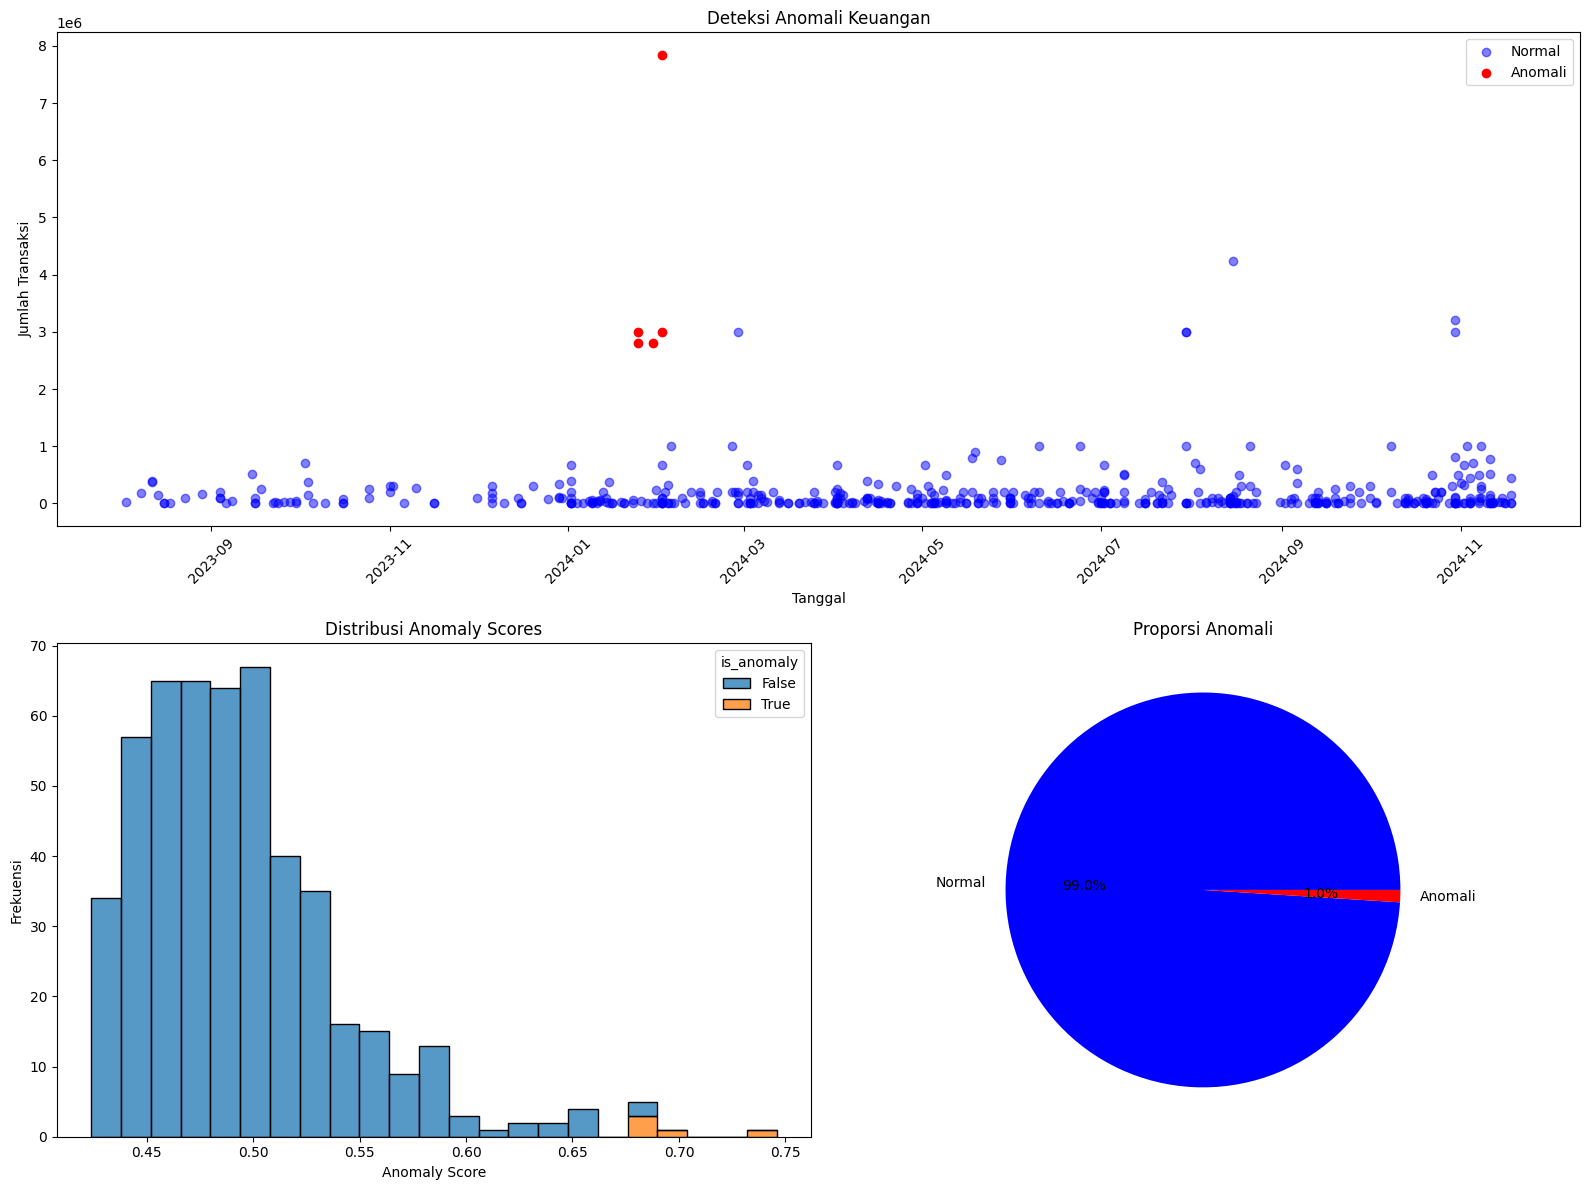

=== LAPORAN DETEKSI ANOMALI ===
Total Transaksi: 499
Jumlah Anomali: 5
Persentase Anomali: 1.00%

--- Detail Anomali ---
Tanggal: 2024-01-25
Jumlah: Rp 2,800,000.00
Anomaly Score: 0.6829
---
Tanggal: 2024-01-25
Jumlah: Rp 3,000,000.00
Anomaly Score: 0.6900
---
Tanggal: 2024-01-30
Jumlah: Rp 2,800,000.00
Anomaly Score: 0.6865
---
Tanggal: 2024-02-02
Jumlah: Rp 7,845,000.00
Anomaly Score: 0.7459
---
Tanggal: 2024-02-02
Jumlah: Rp 3,000,000.00
Anomaly Score: 0.6863
---


In [27]:
def main_expense():
    detector = AdvancedFinancialAnomalyDetector(contamination=0.01)

    # Read dataset
    data = pd.read_json('expense_data.json')

    # Detect anomalies
    result = detector.detect_anomalies(data)

    # Visualisasi
    detector.visualize_anomalies(result)

    # Detailed Report
    detector.detailed_anomaly_report(result)

if __name__ == "__main__":
    main_expense()

## **Cek Anomali**

In [28]:
data1 = pd.read_json('income_data.json')

detector = AdvancedFinancialAnomalyDetector(contamination=0.01)
result = detector.detect_anomalies(data1)

result.head(20)

,date,amount,day_of_week,month,day_of_month,is_anomaly,anomaly_score
0,2023-08-08,190000,1,8,8,False,0.443628
1,2023-08-11,1200000,4,8,11,False,0.456310
2,2023-09-01,1200000,4,9,1,False,0.458827
3,2023-09-04,100000,0,9,4,False,0.506006
4,2023-09-14,37000,3,9,14,False,0.440678
5,2023-09-15,100000,4,9,15,False,0.431062
6,2023-09-28,150000,3,9,28,False,0.465433
7,2023-09-30,20000,5,9,30,False,0.504419
8,2023-10-01,1200000,6,10,1,False,0.515941
9,2023-10-25,10000,2,10,25,False,0.467527


In [29]:
data2 = pd.read_json('expense_data.json')

detector = AdvancedFinancialAnomalyDetector(contamination=0.01)
result = detector.detect_anomalies(data2)

result.head(20)

,date,amount,day_of_week,month,day_of_month,is_anomaly,anomaly_score
0,2023-08-03,20000,3,8,3,False,0.463986
1,2023-08-08,186450,1,8,8,False,0.458126
2,2023-08-12,384000,5,8,12,False,0.513872
3,2023-08-12,400000,5,8,12,False,0.518314
4,2023-08-14,150000,0,8,14,False,0.483677
5,2023-08-16,5500,2,8,16,False,0.425127
6,2023-08-16,2500,2,8,16,False,0.423990
7,2023-08-18,500,4,8,18,False,0.439420
8,2023-08-23,100000,2,8,23,False,0.455929
9,2023-08-29,164000,1,8,29,False,0.503797
